In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame
import numpy as np
import pandas as pd
import re

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', scene_stats_df='scene_stats_df')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.



# Build a Model to Predict Measure of Right Ordering


## Create a data frame with all the feature columns

In [4]:

scene_stats_df = data_frames_list['scene_stats_df']
scene_stats_df.drop(columns=['is_cluster2'], inplace=True)
# print(sorted(scene_stats_df.columns))

In [5]:

# Ensure that you have no duplicate columns in the data frame
mask_series = scene_stats_df.columns.duplicated(keep='first')
if mask_series.any():
    print(scene_stats_df.shape)
    print(scene_stats_df.columns[mask_series].tolist())
    
    # Drop the duplicate columns using the mask
    scene_stats_df.drop(scene_stats_df.columns[mask_series], axis='columns', inplace=True)
    print(scene_stats_df.shape)

In [6]:

frvrs_logs_df = data_frames_list['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829116, 125)

(829116, 125)


In [7]:

# Add the target variable values back into scene stats
target_variable = 'measure_of_right_ordering'
if (target_variable not in scene_stats_df.columns) and (target_variable in frvrs_logs_df.columns):
    for (session_uuid, scene_id, target_variable_value), _ in frvrs_logs_df.groupby(fu.scene_groupby_columns+[target_variable]):
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
        scene_stats_df.loc[mask_series, target_variable] = target_variable_value

In [8]:

# Remove columns to get the best input features
input_features = list(set(scene_stats_df.columns) - set([
    target_variable, 'session_uuid', 'adherence_to_salt', 'stills_value', 'walkers_value', 'actual_distracted_delta', 'measure_of_ideal_ordering',
    'actual_engagement_distance', 'actual_ideal_delta', 'measure_of_distracted_ordering', 'ideal_engagement_distance', 'distracted_engagement_distance'
]))

In [9]:

# Keep track of the target variable and input features columns
columns_list = [target_variable] + input_features
scene_history_df = scene_stats_df[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='any')
print(scene_history_df.shape) # (616, 39)

(551, 39)



## One-hot encode it

In [10]:

# Analyze the data frame for input features that need to be encoded
column_descriptions_df = nu.get_column_descriptions(scene_history_df.sample(min(2000, scene_history_df.shape[0])))
mask_series = (column_descriptions_df.dtype == 'object')
df = column_descriptions_df[mask_series]
display(df)
encodeable_columns = list(set(df.column_name) - set([target_variable]))

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
38,scene_type,object,0,2,0,False,Orientation,Triage,NaN


In [11]:

# One-hot encode the input features columns in the one-hot encoded data frame
ascii_regex = re.compile('[^a-z0-9]+')
one_hot_encode_df = nu.one_hot_encode(scene_history_df, encodeable_columns)
one_hot_encode_df = one_hot_encode_df.rename(columns={cn: ascii_regex.sub('_', cn.lower()).strip('_') for cn in one_hot_encode_df.columns})
columns_obj = one_hot_encode_df.columns
assert len(columns_obj) == len(set(columns_obj)), f"Duplicate column names: {columns_obj[columns_obj.duplicated()].tolist()}"
columns_list = [cn for cn in one_hot_encode_df.columns if any(map(lambda x: cn.endswith(x), ['_null', '_nan']))]
print(one_hot_encode_df.shape) # (31, 79)
print(columns_list)
# df = one_hot_encode_df.sample(min(12, one_hot_encode_df.shape[0])).dropna(axis='columns', how='all').T
# display(df.sample(min(20, df.shape[0])).sort_index())

(551, 41)
['scene_type_nan']



## Train a model on it

In [12]:

# Train a model on the scene history data frame
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
df = one_hot_encode_df.dropna(axis='index', how='any')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_variable], axis='columns'),
    df[target_variable],
    test_size=0.25,
    random_state=42
)

# Convert the uint8 features to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [13]:

# Create a decision tree regressor
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dtr_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
dtr_mse = np.mean((y_pred - y_test)**2)

# Calculate the feature importances
feature_importances = dtr_model.feature_importances_

# Create a data frame to store feature names and importances
feature_importances_df = pd.DataFrame()
feature_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_importances_df['feature_importance'] = feature_importances

In [14]:

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Calculate average squared error
lr_mse = np.mean((y_pred - y_test)**2)

# Get the coefficients of the linear regression model
feature_coefficients = lr_model.coef_[0]

# Create a data frame to store the feature names and feature coefficients
feature_coefficients_df = pd.DataFrame()
feature_coefficients_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_coefficients_df['feature_coefficient'] = feature_coefficients
feature_coefficients_df['absolute_coefficient'] = feature_coefficients_df.feature_coefficient.map(lambda x: abs(x))


## Evaluate the accuracies and importances

In [15]:

# Print the accuracies
print('DTR MSE:', dtr_mse)
print('LR MSE:', lr_mse)

DTR MSE: 0.14656950299580118
LR MSE: 0.10812989768093492


In [16]:

# Display the feature importances data frame
df = feature_importances_df.sort_values('feature_importance', ascending=False).head(10)
dtr_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_importance
34,patient_sort_complexity,0.358715
17,last_still_engagement,0.196955
6,injury_severity_turbulence,0.068293
29,first_engagement,0.049240
33,injury_treatments_count,0.043498
32,time_to_last_hemorrhage_controlled,0.043226
14,patient_sort_turbulence,0.040943
26,total_actions,0.027546
16,wave_command_count,0.027362
0,combo_turbulence,0.020801


In [17]:

# Display the feature coefficients data frame
columns_list = ['feature_name', 'feature_coefficient']
df = feature_coefficients_df.sort_values('absolute_coefficient', ascending=False)[columns_list].head(10)
lr_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_coefficient
0,combo_turbulence,0.010814
1,scene_end,0.010814
22,scene_id,0.010814
23,injury_severity_complexity,0.010814
24,triage_time,0.010814
25,combo_complexity,0.010814
26,total_actions,0.010814
27,voice_capture_count,0.010814
28,is_a_one_triage_file,0.010814
29,first_engagement,0.010814


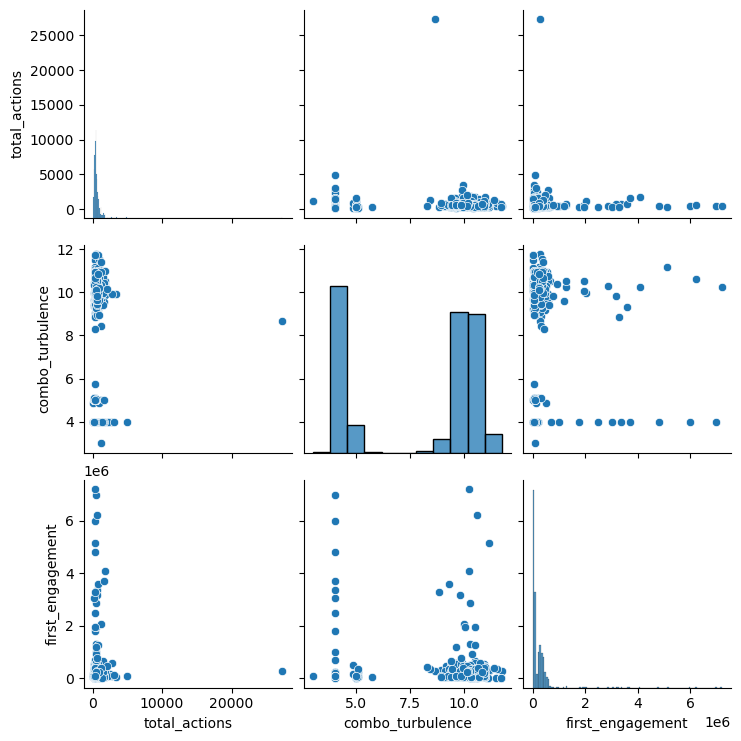

In [100]:

# Get the feature names common to both data frames
import seaborn as sns

importances_list = list(set(dtr_importances_list).intersection(set(lr_importances_list)))
PairGrid_obj = sns.pairplot(scene_history_df[importances_list])


### Visualize Feature Importance


The concept of ‘turbulence’ is well known in hydrodynamics, where it refers to aproperty of ﬂow. A ﬂow is turbulent if its speed and direction are unstable, i.e., changes rapidly and irregularly. Categorical time series like patient engagement order by SORT also consist of ﬂows of events or states in time. We will consider series that have many distinct states and many state changes as being more turbulent than series with fewer distinct states and/or fewer state changes. This implies that the substantive meaning of the various states involved does not play a role in determining the amount of turbulence of the categorical time series.

**Measuring turbulence**: Different measures exist to quantify turbulence in categorical time series. One common approach is the sequence turbulence measure proposed by [Elzinga and Liefbroer (2007)](https://www.researchgate.net/publication/225402919_De-standardization_of_Family-Life_Trajectories_of_Young_Adults_A_Cross-National_Comparison_Using_Sequence_Analysis), which considers both the number of distinct subsequences and the variance of state durations.

**Interpretation**: High turbulence indicates a series with numerous distinct states and frequent transitions, suggesting unpredictability and complexity. Low turbulence signifies a series with fewer distinct states and stable transitions, reflecting order and simplicity.

**Contextual interpretation**: While turbulence measures the formal characteristics of state changes, it's crucial to consider the meaningful interpretation within your specific domain. For example, high turbulence in patient engagement might suggest erratic behavior, while in customer purchase histories, it might reflect diverse interests.

**Limitations**: Turbulence measures don't directly capture the meaning of states or the underlying processes generating the series. Therefore, they should be used in conjunction with other methods that consider domain-specific knowledge.

In [112]:

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def visualize_scene_stats_scatter_plots(x_name, y_name, x_description=None, y_description=None, mask_series=None, verbose=False):
    if x_description is None: x_description = ' '.join([w.title() for w in x_name.split('_')])
    if y_description is None: y_description = ' '.join([w.title() for w in y_name.split('_')])
    
    # Create the scatter plot (mappable object)
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.coolwarm
    if mask_series is None: mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull()
    scatter = ax.scatter(scene_stats_df[mask_series][x_name], scene_stats_df[mask_series][y_name], c=scene_stats_df[mask_series]['measure_of_right_ordering'], cmap=cmap, alpha=0.75)
    
    # Add labels and title
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    ax.set_title(f'Scatter Plot of {x_description} vs {y_description} Colored by Measure of Right Ordering')
    
    # Add the colorbar, referencing the scatter plot
    plt.colorbar(scatter, label='Measure of Right Ordering')  # Use the scatter object as the mappable
    
    # Annotate with Spearman's Rank Correlation Coefficient
    s_str = nu.get_spearman_rho_value_latex(scene_stats_df[mask_series][x_name], scene_stats_df[mask_series][y_name])
    y = 0.9
    if not ('=nan' in s_str):
        text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
        y -= 0.05
    
    # Annotate with Coefficient of Determination
    s_str = nu.get_r_squared_value_latex(scene_stats_df[mask_series][x_name], scene_stats_df[mask_series][y_name])
    text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    
    return ax

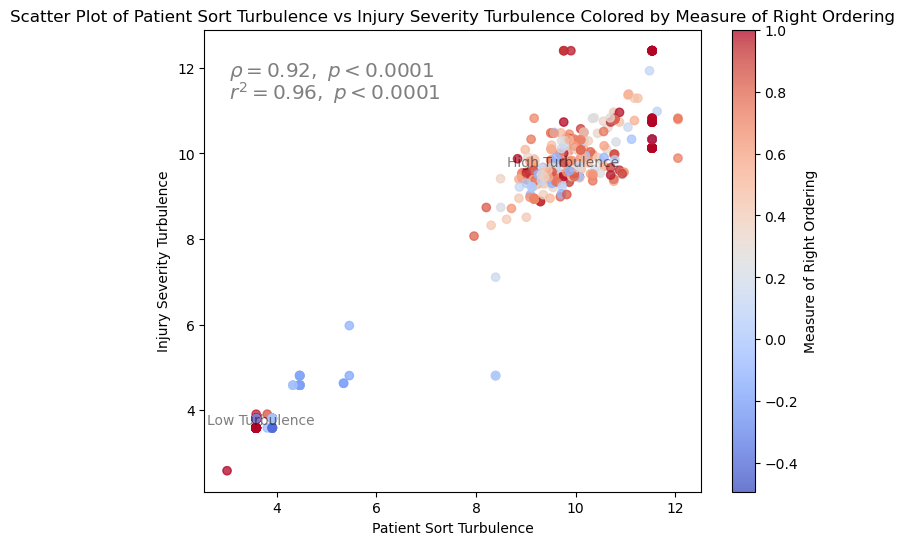

In [134]:

x_name = 'patient_sort_turbulence'
y_name = 'injury_severity_turbulence'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
X = scene_stats_df[columns_list].values
mask = ~np.isnan(X).any(axis=1)
filtered_X = X[mask]
dbscan = DBSCAN(eps=0.5, min_samples=55.0)
dbscan.fit(filtered_X)
labels = dbscan.labels_
annotations_list = ['High Turbulence', 'Low Turbulence']
for i in [0, 1]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(annotations_list[i], centroid, fontsize=10, ha='center', alpha=0.5)

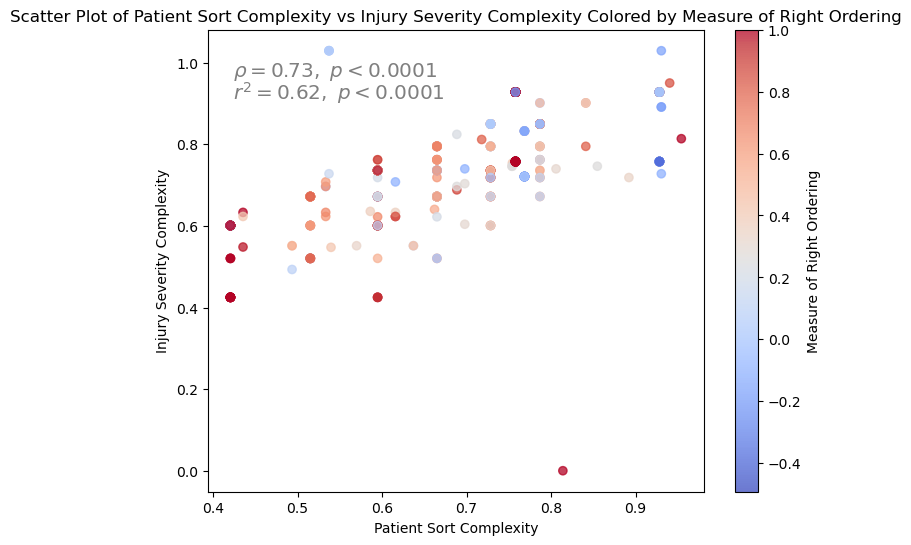

In [114]:

x_name = 'patient_sort_complexity'
y_name = 'injury_severity_complexity'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, verbose=False)

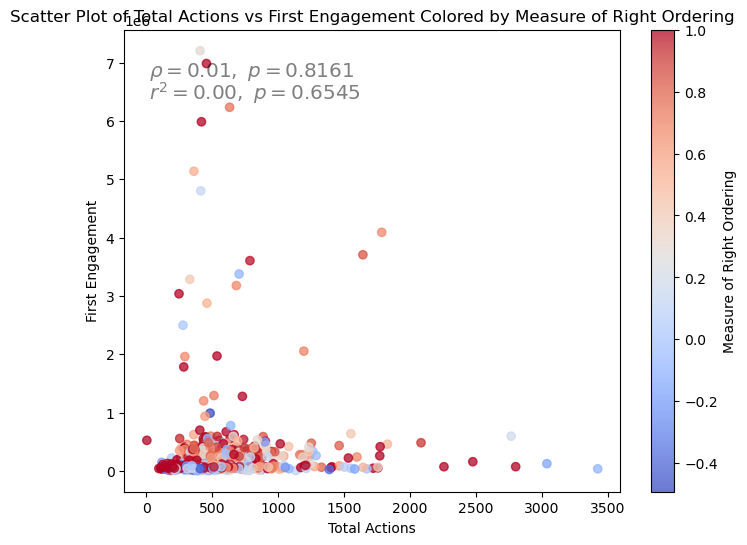

In [123]:

x_name = 'total_actions'
y_name = 'first_engagement'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
ax = visualize_scene_stats_scatter_plots(x_name, y_name, mask_series=mask_series, verbose=False)

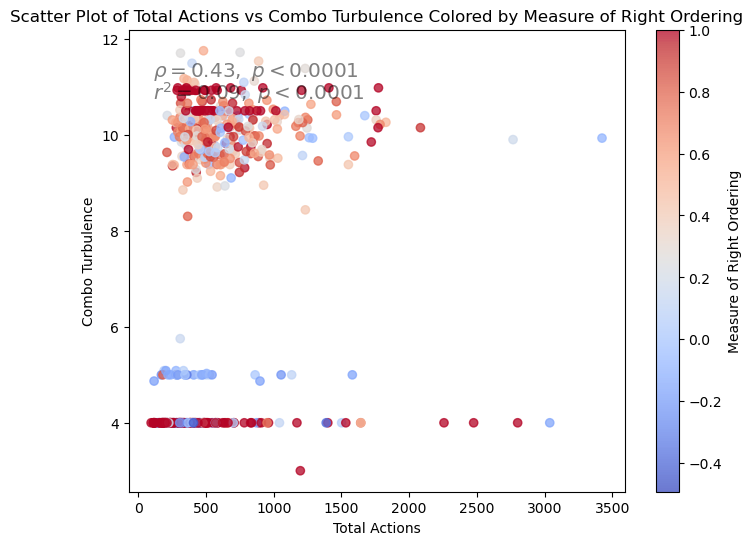

In [180]:

x_name = 'total_actions'
y_name = 'combo_turbulence'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
ax = visualize_scene_stats_scatter_plots(x_name, y_name, mask_series=mask_series, verbose=False)

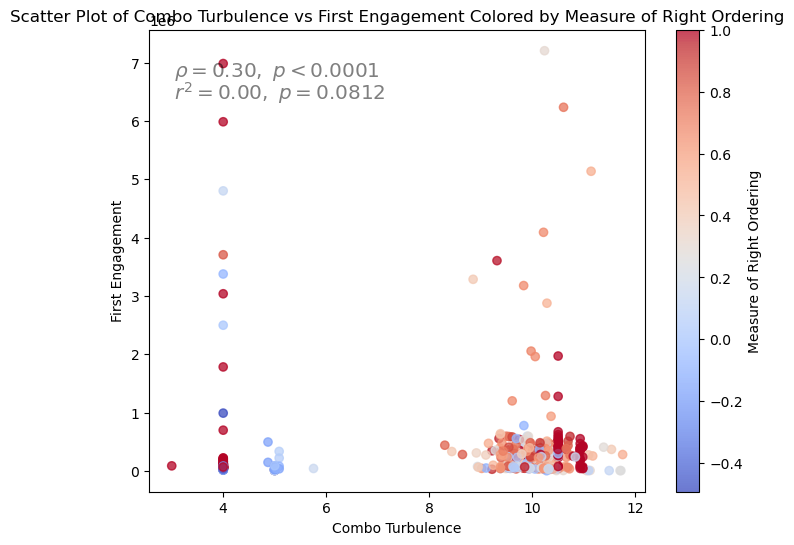

In [181]:

x_name = 'combo_turbulence'
y_name = 'first_engagement'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
ax = visualize_scene_stats_scatter_plots(x_name, y_name, mask_series=mask_series, verbose=False)

[23.37853946 23.81391139]
[5.33281015 4.46489498]
[36.85989632 37.9207784 ]
[40.06310877 58.59366969]


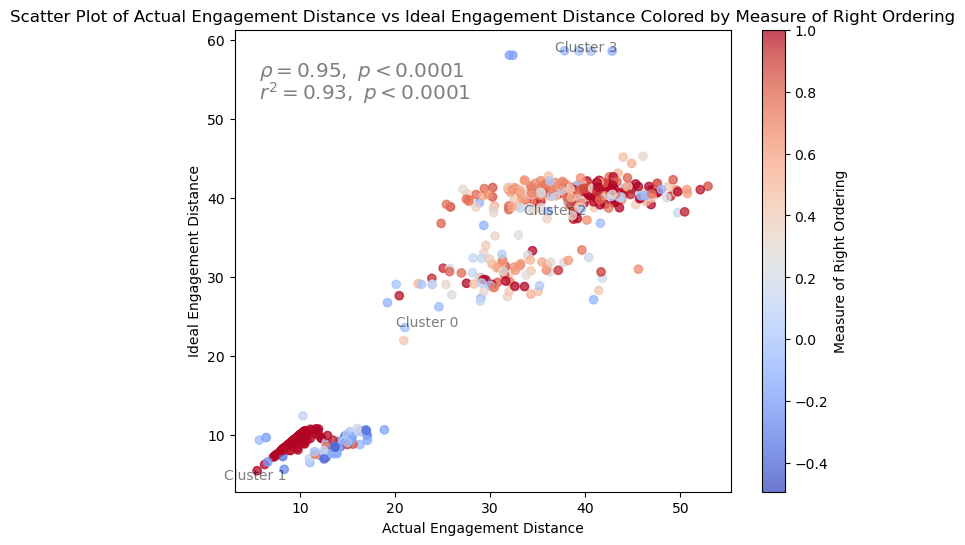

In [179]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull()
ax = visualize_scene_stats_scatter_plots(x_name, y_name, mask_series=mask_series, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
annotations_list = ['High Turbulence', 'Low Turbulence']
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    print(centroid)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)


# Maintenance

In [178]:

# Find dbscan parameter settings
cluster_count = 4
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
for eps in [0.0005, 0.005, 0.0275, 0.05, 0.275, 0.5, 2.75, 5, 27.5, 50, 500]:
    for min_samples in [0, 1, 6, 10, 55, 100, 550, 1000]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(filtered_X)
        labels = dbscan.labels_
        uniques_array, counts_array = np.unique(labels, return_counts=True)
        filtered_array = uniques_array[uniques_array != -1]
        if (filtered_array.shape[0] == cluster_count):
            upper_array = np.unique(labels[(filtered_X[:, 1] > 50)])
            if upper_array[upper_array != -1].shape[0]:
                print(f'dbscan = DBSCAN(eps={eps}, min_samples={min_samples})')
                print(filtered_array)
                print(counts_array[uniques_array != -1])

dbscan = DBSCAN(eps=2.75, min_samples=6)
[0 1 2 3]
[ 12 483 358   6]
dbscan = DBSCAN(eps=5, min_samples=0)
[0 1 2 3]
[375 485  12   1]
dbscan = DBSCAN(eps=5, min_samples=1)
[0 1 2 3]
[375 485  12   1]


In [171]:

filtered_X[:, 1].shape, labels.shape

((873,), (873,))

In [172]:

filtered_X[(filtered_X[:, 1] > 50)]

array([[ 36.13045411,  56.08428593],
       [ 39.32145779,  58.6238369 ],
       [ 32.38248359,  58.05317854],
       [ 37.8098048 ,  58.6231322 ],
       [ 32.02456833,  58.06355996],
       [ 35.5850193 ,  58.03611234],
       [ 39.32645142,  58.57938724],
       [ 32.31503216,  58.03611234],
       [ 91.24793472, 128.14862595],
       [ 40.597501  ,  58.57855394],
       [ 42.82316163,  58.57855394],
       [ 40.500276  ,  58.57855394],
       [ 30.90328614,  58.03611234]])

In [174]:

labels[(filtered_X[:, 1] > 50)]

array([-1,  3, -1,  3, -1, -1,  3, -1, -1,  3,  3,  3, -1])

1

In [173]:

(.item() != -1)

ValueError: can only convert an array of size 1 to a Python scalar

In [157]:

labels[filtered_X[(filtered_X[:, 1] > 35) & (filtered_X[:, 1] < 50)]]

IndexError: arrays used as indices must be of integer (or boolean) type

In [148]:

np.mean([100, 1000])

550.0